# Analyse soil spectra in time

In [5]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pickle
from typing import List
from shapely.geometry import Polygon, MultiPolygon
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.interpolate import interp1d, pchip_interpolate
import matplotlib.pyplot as plt

import os
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
sys.path.insert(0, os.path.join(base_dir, "eodal"))
import eodal

from datetime import datetime
from eodal.config import get_settings
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs
from eodal.utils.reprojection import infer_utm_zone

Settings = get_settings()
# set to False to use a local data archive
Settings.USE_STAC = True

In [ ]:
# Sample EO data in a small known field
# Plot field in time
# Plot a corresponding central pixel's spectra
# Observe what happens during bare soil moments

## 1. Download data for a field (1 year)

In [12]:
def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
    ) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
    interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True, cloud_classes=[3, 8, 9, 10, 11])
    return ds


def extract_s2_data(
        aoi: gpd.GeoDataFrame,
        time_start: datetime,
        time_end: datetime,
        scene_cloud_cover_threshold: float = 50,
        feature_cloud_cover_threshold: float = 80,
        spatial_resolution: int = 10
    ) -> SceneCollection:
    """
    Extracts Sentinel-2 data from the STAC SAT archive for a given area and time period.
    Scenes that are too cloudy or contain nodata (blackfill), only, are discarded.
    Keep only bare soil pixels

    The processing level of the Sentinel-2 data is L2A (surface reflectance factors).

    :param parcel:
        field parcel geometry (defines the spatial extent to extract)
    :param time_start:
        start of the time period to extract
    :param end_time:
        end of the time period to extract
    :param scene_cloud_cover_threshold:
        scene-wide cloudy pixel percentage (from Sentinel-2 metadata) to filter out scenes
        with too high cloud coverage values [0-100%]
    :param feature_cloud_cover_threshold:
        cloudy pixel percentage [0-100%] on the parcel level. Only if the parcel has a
        lower percentual share of cloudy pixels (based on the scene classification layer) than
        the threshold specified, the Sentinel-2 observation is kept
    :param spatial_resolution:
        spatial resolution of the Sentinel-2 data in meters (Def: 10m)
    :param resampling_method:
        spatial resampling method for those Sentinel-2 bands not available in the target
        resolution. Nearest Neighbor by default
    :returns:
        dictionary with the list of scenes for the field parcel (`feature_scenes`), the
        DataFrame of (un)used scenes and the reason for not using plus some basic scene
        metadata (`scene_properties`)
    """
    # setup the metadata filters (cloud cover and processing level)
    metadata_filters = [
        Filter('cloudy_pixel_percentage','<', scene_cloud_cover_threshold),
        Filter('processing_level', '==', 'Level-2A')
    ]
    # setup the spatial feature for extracting data
    feature = Feature.from_geoseries(aoi.geometry)
    
    # set up mapping configs
    mapper_configs = MapperConfigs(
        collection='sentinel2-msi',
        time_start=time_start,
        time_end=time_end,
        feature=feature,
        metadata_filters=metadata_filters
    )

    # get a new mapper instance. Set sensor to `sentinel2`
    mapper = Mapper(mapper_configs)

    # query the STAC (looks for available scenes in the selected spatio-temporal range)
    mapper.query_scenes()

    # get observations (loads the actual Sentinel2 scenes)
    # the data is extract for the extent of the parcel
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,            # this tells the mapper how to read and load the data (i.e., Sentinel-2 scenes)
        'scene_constructor_kwargs': {'band_selection': ['B01','B02','B03', 'B04', 'B05', 'B06', 'B07', 'B08','B8A', 'B11', 'B12', 'SCL']}, # here you could specify which bands to read
        'scene_modifier': preprocess_sentinel2_scenes,       # this tells the mapper about (optional) pre-processing of the loaded scenes (must be a callable)
        'scene_modifier_kwargs': {'target_resolution': spatial_resolution
        }   # here, you have to specify the value of the arguments the `scene_modifier` requires
    }

    mapper.load_scenes(scene_kwargs=scene_kwargs)

    # loop over available Sentinel-2 scenes stored in mapper.data as a EOdal SceneCollection and check
    # for no-data. These scenes will be removed from the SceneCollection
    scenes_to_del = []
    mapper.metadata['scene_used'] = 'yes'

    if mapper.data is not None:
        for scene_id, scene in mapper.data:

            # check if scene is blackfilled (nodata); if yes continue
            if scene.is_blackfilled:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [blackfill]'
                continue

            # check cloud coverage (including shadows and snow) of the field parcel
            feature_cloud_cover = scene.get_cloudy_pixel_percentage(cloud_classes=[3, 8, 9, 10, 11])

            # if the scene is too cloudy, we skip it
            if feature_cloud_cover > feature_cloud_cover_threshold:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [clouds]'
                continue

            # calculate the NDVI and NBR2
            scene.calc_si('NDVI', inplace=True)
            scene.calc_si('NBR2', inplace=True)

            """
            # Check if there are any bare soil pixels
            ndvi = scene.get_band('NDVI').values
            nbr2 =  scene.get_band('NBR2').values
            ndvi.fill_value = np.nan
            nbr2.fill_value = np.nan
            bare_condition = (0 < ndvi) & (ndvi <= 0.25) & (nbr2 <= 0.075)
            bare_soil = np.ma.masked_array(ndvi.data, mask=~bare_condition)
            if not np.sum(~bare_soil.mask): # all pixels are masked -> no bare soil
                scenes_to_del.append(scene_id)
            else:
                #print(scene_id, np.sum(~bare_soil.mask))
                scene.mask(bare_soil.mask, keep_mask_values=True, inplace=True)
                # Save the number of bare soil pixels
                mapper.metadata.loc[mapper.metadata['sensing_date'] == scene_id.date(), 'n_bare'] = np.sum(~bare_soil.mask)
            """
            
                
        # delete scenes too cloudy or containing only no-data or with no bare soil pixels
        for scene_id in scenes_to_del:
            del mapper.data[scene_id]
        # Keep only metadata for corresponding scenes
        dates_to_del = [scene_id.date() for scene_id in scenes_to_del]
        mapper.metadata = mapper.metadata[~mapper.metadata['sensing_date'].isin(dates_to_del)]
    
    return mapper

In [23]:
# Data from Strickhof farm (Eschikon)
shp_path = base_dir.joinpath(f'data/Strickhof.shp')
save_path = base_dir.joinpath(f'results/monitor_BS_data.pkl')
metadata_path = save_path.with_name(save_path.name.replace('data', 'metadata'))

geom = gpd.read_file(shp_path)

In [17]:
res_baresoil = extract_s2_data(
    aoi=geom.dissolve(), 
    time_start=datetime(2021,1,1),
    time_end=datetime(2021,12,31),
)

2024-03-06 13:18:36,336 eodal        INFO     Starting extraction of sentinel2 scenes
2024-03-06 13:20:26,700 eodal        INFO     Finished extraction of sentinel2 scenes


In [24]:
# Save data for future use
with open(save_path, 'wb+') as dst:
  dst.write(res_baresoil.data.to_pickle())     
with open(metadata_path, 'wb+') as dst:
  pickle.dump(res_baresoil.metadata, dst)

## 2. Load data

In [26]:
scoll = SceneCollection.from_pickle(stream=save_path)
metadata = pd.read_pickle(metadata_path)

## 3. View data in time

In [80]:
def plot_scenes_by_month(scoll: SceneCollection) -> None:
    
    ts = scoll.timestamps
    ts_datetime = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in ts]

    # Plot month by month
    for month_nbr in range(1, 13):
        # Filter elements for the current month
        month_ts = [t for t in ts_datetime if t.month == month_nbr]
        month_ts_str = [timestamp.strftime('%Y-%m-%d %H:%M:%S') for timestamp in month_ts]
        
        # scoll.__getitem__(month_ts_str[0])
        if len(month_ts_str):
            f, axes = plt.subplots(ncols=len(month_ts_str), nrows=1, figsize=(3*len(month_ts_str),4))

            if len(month_ts_str) == 1:
                axes = [axes]

            for i, t in enumerate(month_ts_str):
                scene = scoll.__getitem__(t)
                scene.plot_multiple_bands(band_selection=['red','green','blue'], ax=axes[i])
                axes[i].set_title(t)

            plt.tight_layout()

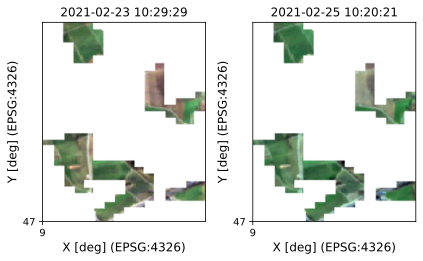

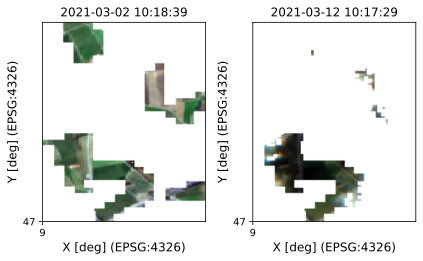

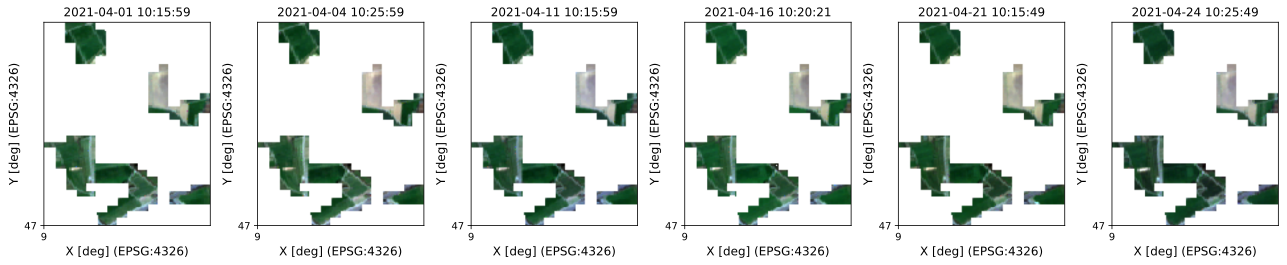

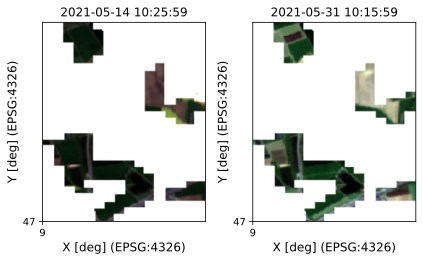

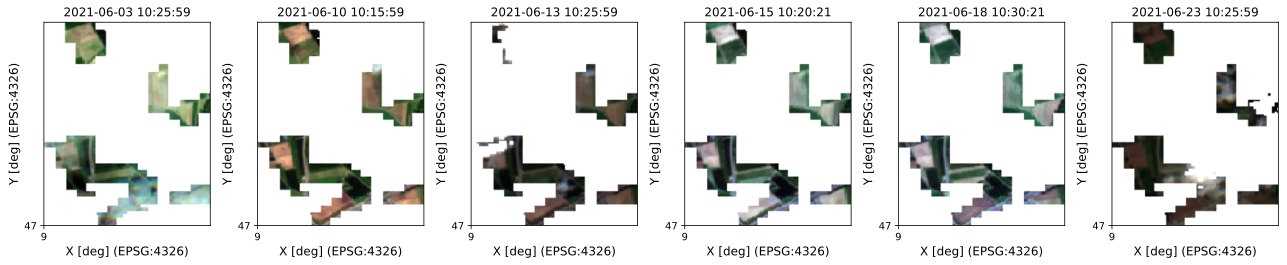

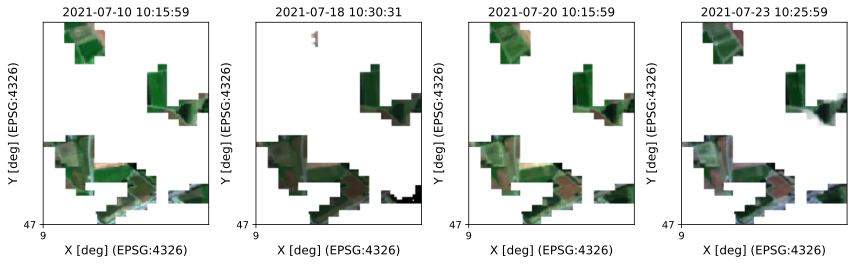

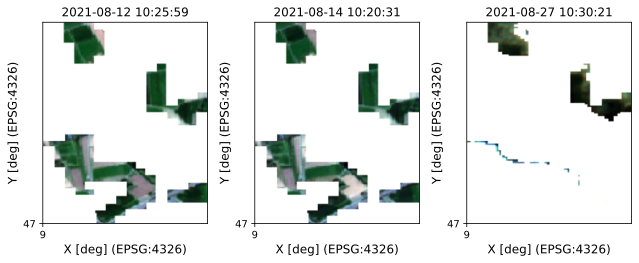

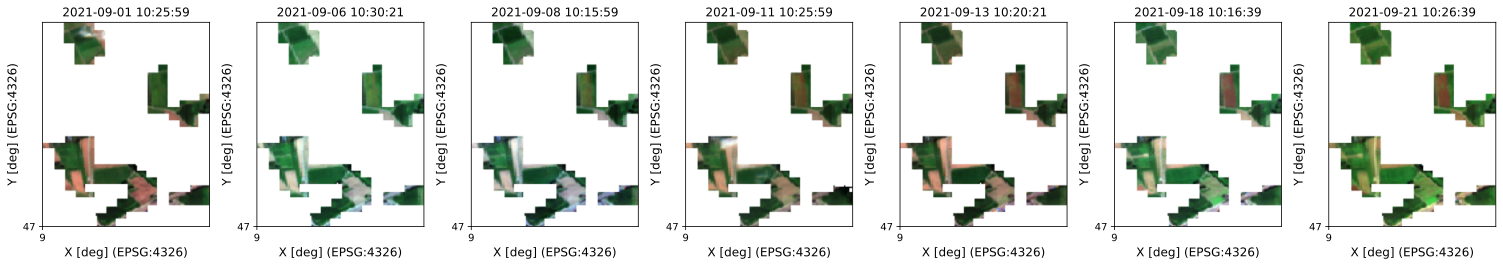

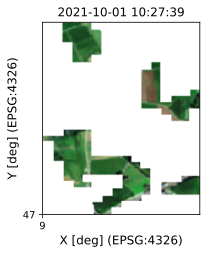

In [81]:
plot_scenes_by_month(scoll)

## 4. View data and compare to spectra 